<a href="https://colab.research.google.com/github/dgambone3/CSC4850-Machine-Learning/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import numpy as np

# metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import ConfusionMatrixDisplay


# processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier

In [13]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_Project/Diabetes Indicators Dataset/diabetes_012_health_indicators_BRFSS2015.csv')

In [14]:
# print(df.shape)
# print(df[df['Diabetes_012'] != 0].shape, 'not zeros - to under sample data')
# data = df[df['Diabetes_012']]
X = df.iloc[:, 1:] # features
X = X.astype(int)
y = df.iloc[:, :1]
y = y.astype(int).values.ravel()

#### Split original data into three seperate ratios
###### Initialize dataframe labels and plot colors



In [15]:
#### SPLIT FOR FASTER TESTING -  REMOVE FOR FINAL TESTS ####
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, 
                                                                        y, 
                                                                        train_size=0.050)
# Create all three splits outside of loop to run each model on same data splits
X55_train, X55_test, y55_train, y55_test = train_test_split(X_train_temp, 
                                                            y_train_temp, 
                                                            train_size=.5, 
                                                            test_size=.5, 
                                                            shuffle=True,
                                                            random_state=1234)
X73_train, X73_test, y73_train, y73_test = train_test_split(X_train_temp, 
                                                            y_train_temp, 
                                                            train_size=.7, 
                                                            test_size=.3, 
                                                            shuffle=True,
                                                            random_state=1234)
X82_train, X82_test, y82_train, y82_test = train_test_split(X_train_temp, 
                                                            y_train_temp, 
                                                            train_size=.8, 
                                                            test_size=.2, 
                                                            shuffle=True,
                                                            random_state=1234)
# List of train and test motels to access later in loop
train = [(X55_train, y55_train), 
         (X73_train, y73_train), 
         (X82_train, y82_train)]
test = [(X55_test, y55_test),
        (X73_test, y73_test),
        (X82_test, y82_test)]

# initialize lists of color for plots
train_colors = ['navy', 'green', 'firebrick']
test_colors = ['skyblue', 'palegreen', 'salmon']

#### Initialize models

In [16]:
titles = ['Decision Tree',
          'Perceptron',
          'Multinomial Naive Bayes',
          'Logistic Regression',
          'Linear Regression',
          'SVM - Linear',
          'SVM - RBF',
          'Gradient Boost',
          'Muti-Layer Perceptron',
          'Regularilized Linear Regression',
          'Lasso Linear Regression',
          'k-Nearest Neighbors',
          'Linear Regression with Optimal Polynomial']
          # 'SVM - Linear']

models = [DecisionTreeClassifier(criterion='gini', splitter='best'),
          Perceptron(),
          MultinomialNB(),
          LogisticRegression(solver='liblinear'), 
          LinearRegression(),
          LinearSVC(dual=False),
          SVC(kernel='rbf', decision_function_shape='ovr'),
          GradientBoostingClassifier(),
          MLPClassifier(max_iter=500, hidden_layer_sizes=10),
          SGDRegressor(loss='squared_error', penalty='l2'),
          Lasso(selection='random'),
          KNeighborsClassifier(weights='distance'),
          LinearRegression()]
          # LinearSVC(dual=False)]

# list of split ratios to output onto plots
splits = [(0.5, 0.5), 
          (0.7, 0.3),
          (0.8, 0.2)]

# create labels for fold metrics dataframe
index = []
for i in range(1,11):
  index.append(f'Fold {i}')

#### Methods to get various metric scores

In [17]:
def get_acc_score(mod, X, y):
  pred = mod.predict(X)
  return accuracy_score(y_true=y, y_pred=np.around(pred))

def get_prec_score(mod, X, y):
  pred = mod.predict(X)
  return precision_score(y_true=y, y_pred=np.around(pred), average='weighted', zero_division=0)

def get_recall_score(mod, X, y):
  pred = mod.predict(X)
  return recall_score(y_true=y, y_pred=np.around(pred),average='weighted', zero_division=0)

def get_f1_score(mod, X, y):
  pred = mod.predict(X)
  return f1_score(y_true=y, y_pred=np.around(pred),average='weighted', zero_division=0)

def get_error_score(mod, X, y):
  pred = mod.predict(X)
  return MSE(y_true=y, y_pred=pred)

#### Get learning curve plot

In [18]:
def get_learning_curve(model, X, y, title):
  scores=[]
  perc=[]
  for n in range(1,101):
    perc.append(n)
    XX = X.iloc[0:int(len(X) * (n/100))] #df
    yy = y[0:int(len(y) * (n/100))] #list
    pred = model.predict(XX)
    score = MSE(y_true=yy, y_pred=pred)
    scores.append(score)
  return pd.DataFrame({'percent':perc, 'scores':scores})

#### Function to find best polynomial for linear regression

In [19]:
def best_poly(X_train, y_train, X_test, y_test):
  degree = [1, 2]
  z = []
  poly_df = pd.DataFrame(columns=['polynomial', 'score'])
  print('   Polynomial Scores')
  for deg in degree:
    linreg = LinearRegression()
    polynomial_features = PolynomialFeatures(degree=deg,
                                             include_bias=False)
    lin_pipe = Pipeline([('scaler', MinMaxScaler()),
                        ("polynomial_features", polynomial_features),
                        ("linear_regression", linreg)])
    lin_pipe.fit(X,y)
    score = lin_pipe.score(X_test,y_test)
    z.append(score)
    print(f'Degree: {deg}  Score: {score}')
  p = z.index(max(z)) + 1
    
  return p

### Loop to train and test models on all 3 splits and output plots and tables with metric details for each fold, and split

Decision Tree
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.773228,0.794569,0.773228,0.782979,0.812598
1,0.744882,0.758590,0.744882,0.751271,0.944882
2,0.766562,0.778119,0.766562,0.772103,0.843849
3,0.761830,0.767697,0.761830,0.764752,0.843849
4,0.763407,0.767065,0.763407,0.765193,0.875394
5,0.758675,0.763573,0.758675,0.761114,0.856467
6,0.752366,0.769573,0.752366,0.760816,0.862776
7,0.771293,0.780649,0.771293,0.775709,0.824921
8,0.757098,0.782448,0.757098,0.768994,0.848580
9,0.783912,0.785452,0.783912,0.784669,0.755521


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.761261,0.778033,0.761261,0.769246,0.863739
1,0.768018,0.784296,0.768018,0.775738,0.829955
2,0.735360,0.765440,0.735360,0.749294,0.957207
3,0.752252,0.770733,0.752252,0.760767,0.923423
4,0.754505,0.765011,0.754505,0.759555,0.897523
5,0.743243,0.765479,0.743243,0.753837,0.908784
6,0.769144,0.783681,0.769144,0.775815,0.845721
7,0.757883,0.765230,0.757883,0.761482,0.870495
8,0.751973,0.769401,0.751973,0.760340,0.887260
9,0.763247,0.772075,0.763247,0.767622,0.835400


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.758621,0.770271,0.758621,0.764302,0.859113
1,0.759606,0.776028,0.759606,0.767508,0.846305
2,0.774384,0.779068,0.774384,0.776699,0.804926
3,0.752709,0.772286,0.752709,0.761948,0.882759
4,0.753695,0.767311,0.753695,0.760304,0.878818
5,0.761576,0.772402,0.761576,0.766828,0.853202
6,0.755665,0.772808,0.755665,0.763666,0.882759
7,0.788955,0.806289,0.788955,0.796907,0.749507
8,0.760355,0.780796,0.760355,0.770008,0.846154
9,0.775148,0.788111,0.775148,0.781386,0.792899


Perceptron
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.844094,0.712496,0.844094,0.772732,0.576378
1,0.844094,0.784415,0.844094,0.778516,0.576378
2,0.843849,0.786766,0.843849,0.783481,0.582019
3,0.842271,0.788773,0.842271,0.800553,0.588328
4,0.831230,0.776830,0.831230,0.794497,0.632492
5,0.817035,0.791669,0.817035,0.803508,0.689274
6,0.774448,0.811460,0.774448,0.788117,0.859621
7,0.758675,0.831906,0.758675,0.780991,0.917981
8,0.843849,0.712080,0.843849,0.772385,0.577287
9,0.616719,0.835032,0.616719,0.687038,0.586751


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.835586,0.804800,0.835586,0.817931,0.613739
1,0.846847,0.816827,0.846847,0.788550,0.561937
2,0.845721,0.801931,0.845721,0.785989,0.569820
3,0.844595,0.786334,0.844595,0.790702,0.574324
4,0.844595,0.792022,0.844595,0.786075,0.574324
5,0.827703,0.776019,0.827703,0.795128,0.638514
6,0.837838,0.785329,0.837838,0.799404,0.601351
7,0.850225,0.806241,0.850225,0.807385,0.548423
8,0.744081,0.832713,0.744081,0.785845,0.634724
9,0.808343,0.806732,0.808343,0.807495,0.678692


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.844335,0.805061,0.844335,0.818131,0.575369
1,0.848276,0.800105,0.848276,0.805011,0.559606
2,0.847291,0.805619,0.847291,0.790603,0.563547
3,0.836453,0.779554,0.836453,0.793302,0.603941
4,0.833498,0.790494,0.833498,0.806784,0.618719
5,0.838424,0.780000,0.838424,0.789773,0.593103
6,0.744828,0.799855,0.744828,0.770392,0.689655
7,0.839250,0.793714,0.839250,0.807821,0.598619
8,0.845168,0.807554,0.845168,0.779709,0.571992
9,0.843195,0.782063,0.843195,0.773331,0.579882


Multinomial Naive Bayes
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.834646,0.786950,0.834646,0.803464,0.614173
1,0.840945,0.790761,0.840945,0.804783,0.588976
2,0.828076,0.777750,0.828076,0.795138,0.645110
3,0.828076,0.771366,0.828076,0.790738,0.645110
4,0.831230,0.778829,0.831230,0.796128,0.632492
5,0.832808,0.780520,0.832808,0.797191,0.626183
6,0.835962,0.787519,0.835962,0.802488,0.613565
7,0.828076,0.773185,0.828076,0.791865,0.640379
8,0.831230,0.781867,0.831230,0.799520,0.627760
9,0.837539,0.779243,0.837539,0.795548,0.602524


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.849099,0.805692,0.849099,0.814079,0.559685
1,0.855856,0.818989,0.855856,0.823006,0.532658
2,0.824324,0.777413,0.824324,0.795450,0.658784
3,0.840090,0.795257,0.840090,0.809654,0.592342
4,0.832207,0.782184,0.832207,0.799263,0.623874
5,0.823198,0.771205,0.823198,0.791002,0.659910
6,0.833333,0.779423,0.833333,0.796662,0.619369
7,0.834459,0.784723,0.834459,0.800521,0.614865
8,0.824126,0.772951,0.824126,0.792376,0.659526
9,0.838782,0.784074,0.838782,0.798636,0.600902


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.825616,0.774609,0.825616,0.793274,0.650246
1,0.844335,0.795840,0.844335,0.807851,0.575369
2,0.853202,0.814244,0.853202,0.818343,0.539901
3,0.828571,0.781877,0.828571,0.798945,0.638424
4,0.839409,0.791672,0.839409,0.806093,0.595074
5,0.825616,0.772070,0.825616,0.791346,0.650246
6,0.825616,0.771569,0.825616,0.790942,0.650246
7,0.836292,0.788794,0.836292,0.803673,0.610454
8,0.820513,0.764781,0.820513,0.785893,0.670611
9,0.837278,0.784161,0.837278,0.799635,0.603550


Logistic Regression
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.839370,0.782961,0.839370,0.799123,0.595276
1,0.850394,0.806024,0.850394,0.803769,0.551181
2,0.850158,0.807327,0.850158,0.810789,0.556782
3,0.839117,0.779205,0.839117,0.792357,0.600946
4,0.840694,0.784038,0.840694,0.792901,0.594637
5,0.837539,0.778695,0.837539,0.793298,0.607256
6,0.845426,0.794868,0.845426,0.800370,0.575710
7,0.843849,0.793686,0.843849,0.800702,0.577287
8,0.851735,0.809598,0.851735,0.808310,0.545741
9,0.843849,0.784319,0.843849,0.793725,0.577287


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.851351,0.807942,0.851351,0.814829,0.550676
1,0.855856,0.822282,0.855856,0.813690,0.532658
2,0.850225,0.808369,0.850225,0.810926,0.555180
3,0.841216,0.786708,0.841216,0.798713,0.587838
4,0.847973,0.802547,0.847973,0.810223,0.560811
5,0.832207,0.767139,0.832207,0.786660,0.623874
6,0.836712,0.777160,0.836712,0.792285,0.605856
7,0.845721,0.795331,0.845721,0.802535,0.569820
8,0.845547,0.797518,0.845547,0.805407,0.573844
9,0.846674,0.794952,0.846674,0.799841,0.569335


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.848276,0.804233,0.848276,0.803107,0.559606
1,0.854187,0.813514,0.854187,0.819678,0.535961
2,0.851232,0.811732,0.851232,0.807458,0.547783
3,0.845320,0.799117,0.845320,0.807831,0.571429
4,0.842365,0.789150,0.842365,0.799632,0.583251
5,0.843350,0.791879,0.843350,0.800031,0.579310
6,0.838424,0.785665,0.838424,0.798243,0.599015
7,0.843195,0.790378,0.843195,0.798985,0.582840
8,0.844181,0.792372,0.844181,0.802152,0.575937
9,0.843195,0.789088,0.843195,0.797761,0.579882


Linear Regression
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.702362,0.763759,0.702362,0.730984,0.439082
1,0.713386,0.796377,0.713386,0.748202,0.382522
2,0.714511,0.782242,0.714511,0.741572,0.391521
3,0.687697,0.765451,0.687697,0.720117,0.433108
4,0.712934,0.795968,0.712934,0.751383,0.389657
5,0.722397,0.772783,0.722397,0.743043,0.393915
6,0.716088,0.771981,0.716088,0.739355,0.415898
7,0.687697,0.751642,0.687697,0.715370,0.437630
8,0.692429,0.759568,0.692429,0.721336,0.447289
9,0.722397,0.763779,0.722397,0.739139,0.414942


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.702703,0.760201,0.702703,0.727729,0.426287
1,0.742117,0.792636,0.742117,0.762701,0.366641
2,0.692568,0.851747,0.692568,0.732487,0.402801
3,0.697072,0.786393,0.697072,0.737344,0.413988
4,0.715090,0.789785,0.715090,0.745210,0.384190
5,0.686937,0.780394,0.686937,0.726889,0.416368
6,0.716216,0.780849,0.716216,0.744076,0.402782
7,0.711712,0.762708,0.711712,0.732536,0.409450
8,0.691094,0.767399,0.691094,0.724986,0.434981
9,0.713641,0.762803,0.713641,0.733946,0.426843


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.692611,0.766872,0.692611,0.723933,0.410934
1,0.692611,0.762946,0.692611,0.723318,0.418937
2,0.737931,0.794946,0.737931,0.761874,0.373914
3,0.690640,0.847623,0.690640,0.728912,0.414974
4,0.705419,0.799879,0.705419,0.747240,0.390462
5,0.700493,0.771389,0.700493,0.728731,0.411170
6,0.695567,0.786494,0.695567,0.736778,0.404309
7,0.716963,0.789578,0.716963,0.748022,0.380873
8,0.686391,0.748125,0.686391,0.712253,0.451109
9,0.708087,0.765744,0.708087,0.732625,0.424905


SVM - Linear
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.848819,0.797677,0.848819,0.797020,0.557480
1,0.848819,0.808836,0.848819,0.793860,0.557480
2,0.847003,0.801111,0.847003,0.794819,0.569401
3,0.847003,0.796666,0.847003,0.790758,0.569401
4,0.843849,0.784901,0.843849,0.778180,0.582019
5,0.843849,0.786039,0.843849,0.791115,0.582019
6,0.845426,0.789061,0.845426,0.787420,0.575710
7,0.843849,0.787868,0.843849,0.788322,0.577287
8,0.843849,0.785042,0.843849,0.780882,0.577287
9,0.848580,0.797622,0.848580,0.789792,0.558360


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.850225,0.801359,0.850225,0.798092,0.555180
1,0.851351,0.816118,0.851351,0.799401,0.550676
2,0.849099,0.805493,0.849099,0.800926,0.559685
3,0.843468,0.782884,0.843468,0.790014,0.578829
4,0.851351,0.817484,0.851351,0.800072,0.547297
5,0.844595,0.787428,0.844595,0.786448,0.574324
6,0.841216,0.772240,0.841216,0.782732,0.587838
7,0.847973,0.802318,0.847973,0.793526,0.560811
8,0.847802,0.803080,0.847802,0.793856,0.564825
9,0.846674,0.788748,0.846674,0.785269,0.569335


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.852217,0.819786,0.852217,0.802055,0.543842
1,0.847291,0.792099,0.847291,0.794650,0.563547
2,0.851232,0.821602,0.851232,0.797378,0.547783
3,0.847291,0.801837,0.847291,0.797509,0.563547
4,0.846305,0.796242,0.846305,0.791744,0.567488
5,0.846305,0.799599,0.846305,0.791444,0.567488
6,0.842365,0.783653,0.842365,0.787124,0.583251
7,0.844181,0.785044,0.844181,0.787776,0.578895
8,0.844181,0.791393,0.844181,0.790022,0.575937
9,0.844181,0.783546,0.844181,0.786273,0.575937


SVM - RBF
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.844094,0.712496,0.844094,0.772732,0.576378
1,0.844094,0.712496,0.844094,0.772732,0.576378
2,0.843849,0.712080,0.843849,0.772385,0.582019
3,0.843849,0.712080,0.843849,0.772385,0.582019
4,0.843849,0.783977,0.843849,0.775348,0.582019
5,0.843849,0.712080,0.843849,0.772385,0.582019
6,0.839117,0.711454,0.839117,0.770030,0.600946
7,0.843849,0.712080,0.843849,0.772385,0.577287
8,0.845426,0.853584,0.845426,0.776166,0.570978
9,0.843849,0.712080,0.843849,0.772385,0.577287


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.844595,0.713340,0.844595,0.773438,0.577703
1,0.845721,0.854910,0.845721,0.776145,0.573198
2,0.842342,0.761284,0.842342,0.776440,0.586712
3,0.845721,0.853784,0.845721,0.776145,0.569820
4,0.843468,0.782476,0.843468,0.773978,0.578829
5,0.843468,0.783793,0.843468,0.778032,0.578829
6,0.843468,0.712241,0.843468,0.772320,0.578829
7,0.836712,0.738262,0.836712,0.772910,0.605856
8,0.846674,0.855580,0.846674,0.778576,0.569335
9,0.844419,0.713044,0.844419,0.773191,0.578354


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.844335,0.797622,0.844335,0.777652,0.575369
1,0.844335,0.852827,0.844335,0.774050,0.575369
2,0.844335,0.852827,0.844335,0.774050,0.575369
3,0.844335,0.797622,0.844335,0.777652,0.575369
4,0.844335,0.852827,0.844335,0.774050,0.575369
5,0.845320,0.853530,0.845320,0.776393,0.571429
6,0.841379,0.767337,0.841379,0.773454,0.587192
7,0.843195,0.759591,0.843195,0.773731,0.582840
8,0.844181,0.852706,0.844181,0.773834,0.575937
9,0.843195,0.710978,0.843195,0.771463,0.579882


Gradient Boost
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.847244,0.802723,0.847244,0.811948,0.563780
1,0.844094,0.794974,0.844094,0.802799,0.576378
2,0.842271,0.791806,0.842271,0.804029,0.588328
3,0.850158,0.809541,0.850158,0.818822,0.556782
4,0.854890,0.819693,0.854890,0.815487,0.537855
5,0.831230,0.778829,0.831230,0.796128,0.632492
6,0.847003,0.801285,0.847003,0.810577,0.569401
7,0.840694,0.788220,0.840694,0.800758,0.589905
8,0.850158,0.806068,0.850158,0.808990,0.552050
9,0.856467,0.819409,0.856467,0.823020,0.526814


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.854730,0.816062,0.854730,0.822092,0.533784
1,0.862613,0.830044,0.862613,0.834969,0.505631
2,0.838964,0.793741,0.838964,0.807670,0.600225
3,0.843468,0.793599,0.843468,0.805496,0.578829
4,0.843468,0.798984,0.843468,0.811364,0.578829
5,0.838964,0.787742,0.838964,0.800651,0.593468
6,0.837838,0.788648,0.837838,0.802858,0.601351
7,0.856982,0.817903,0.856982,0.822712,0.524775
8,0.848929,0.807536,0.848929,0.812736,0.556933
9,0.852311,0.811392,0.852311,0.817401,0.546787


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.841379,0.791428,0.841379,0.804558,0.587192
1,0.854187,0.814527,0.854187,0.822361,0.535961
2,0.850246,0.807115,0.850246,0.814728,0.551724
3,0.845320,0.801941,0.845320,0.813919,0.571429
4,0.841379,0.791428,0.841379,0.804558,0.587192
5,0.843350,0.796058,0.843350,0.806447,0.579310
6,0.842365,0.798997,0.842365,0.810274,0.580296
7,0.844181,0.796648,0.844181,0.807494,0.578895
8,0.844181,0.798195,0.844181,0.808602,0.572978
9,0.856016,0.818592,0.856016,0.821478,0.528600


Muti-Layer Perceptron
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.840945,0.795481,0.840945,0.808947,0.588976
1,0.834646,0.763584,0.834646,0.782944,0.614173
2,0.848580,0.803156,0.848580,0.806211,0.563091
3,0.845426,0.797857,0.845426,0.805795,0.575710
4,0.853312,0.817926,0.853312,0.809101,0.544164
5,0.843849,0.794031,0.843849,0.802980,0.582019
6,0.856467,0.818637,0.856467,0.818929,0.531546
7,0.839117,0.780118,0.839117,0.791844,0.596215
8,0.843849,0.793686,0.843849,0.800702,0.577287
9,0.842271,0.792002,0.842271,0.803533,0.583596


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.858108,0.819888,0.858108,0.824323,0.523649
1,0.851351,0.808118,0.851351,0.812242,0.550676
2,0.842342,0.789326,0.842342,0.801110,0.586712
3,0.843468,0.796024,0.843468,0.807524,0.578829
4,0.850225,0.805967,0.850225,0.813222,0.551802
5,0.841216,0.790198,0.841216,0.801703,0.587838
6,0.844595,0.797201,0.844595,0.806422,0.574324
7,0.854730,0.815545,0.854730,0.816202,0.533784
8,0.843292,0.792115,0.843292,0.799739,0.582864
9,0.846674,0.798513,0.846674,0.806464,0.569335


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.843350,0.791164,0.843350,0.798872,0.579310
1,0.849261,0.803351,0.849261,0.811301,0.555665
2,0.845320,0.795724,0.845320,0.805197,0.571429
3,0.840394,0.791043,0.840394,0.804868,0.591133
4,0.835468,0.776711,0.835468,0.792519,0.610837
5,0.843350,0.793236,0.843350,0.803598,0.579310
6,0.850246,0.808836,0.850246,0.811701,0.551724
7,0.842209,0.792768,0.842209,0.803842,0.586785
8,0.852071,0.810854,0.852071,0.814784,0.544379
9,0.840237,0.789466,0.840237,0.802426,0.591716


Regularilized Linear Regression
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.670866,0.762088,0.670866,0.712739,0.451749
1,0.683465,0.798835,0.683465,0.731936,0.388982
2,0.744479,0.770883,0.744479,0.752824,0.395924
3,0.686120,0.762111,0.686120,0.718495,0.434231
4,0.682965,0.798261,0.682965,0.733621,0.398957
5,0.757098,0.764566,0.757098,0.757683,0.400421
6,0.692429,0.776038,0.692429,0.727219,0.420109
7,0.700315,0.746849,0.700315,0.720075,0.440256
8,0.698738,0.755602,0.698738,0.723776,0.453938
9,0.747634,0.744763,0.747634,0.744445,0.421198


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.656532,0.766338,0.656532,0.703721,0.433066
1,0.763514,0.775924,0.763514,0.767542,0.380537
2,0.699324,0.779594,0.699324,0.732538,0.407312
3,0.709459,0.779416,0.709459,0.741157,0.418558
4,0.704955,0.787765,0.704955,0.738570,0.387291
5,0.679054,0.774892,0.679054,0.719988,0.419538
6,0.745495,0.772860,0.745495,0.756159,0.406947
7,0.734234,0.760735,0.734234,0.744176,0.412788
8,0.701240,0.758274,0.701240,0.727007,0.439811
9,0.722661,0.755022,0.722661,0.735176,0.428840


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.668966,0.769850,0.668966,0.711689,0.417744
1,0.735961,0.753726,0.735961,0.742725,0.428755
2,0.711330,0.788807,0.711330,0.744849,0.383035
3,0.702463,0.771312,0.702463,0.731181,0.419901
4,0.723153,0.787119,0.723153,0.751020,0.393580
5,0.746798,0.750561,0.746798,0.745305,0.417202
6,0.679803,0.785000,0.679803,0.726108,0.409571
7,0.728797,0.785694,0.728797,0.752394,0.386056
8,0.694280,0.750024,0.694280,0.717910,0.451517
9,0.695266,0.764531,0.695266,0.725007,0.428339


Lasso Linear Regression
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.840945,0.707188,0.840945,0.768288,0.520359
1,0.859843,0.739329,0.859843,0.795045,0.444707
2,0.840694,0.706766,0.840694,0.767935,0.479255
3,0.835962,0.698833,0.835962,0.761271,0.507776
4,0.861199,0.741663,0.861199,0.796974,0.455960
5,0.848580,0.720089,0.848580,0.779072,0.457161
6,0.845426,0.714745,0.845426,0.774612,0.492512
7,0.831230,0.690944,0.831230,0.754622,0.524970
8,0.834385,0.696198,0.834385,0.759053,0.531279
9,0.840694,0.706766,0.840694,0.767935,0.498233


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.831081,0.690696,0.831081,0.754413,0.530900
1,0.849099,0.720969,0.849099,0.779806,0.471922
2,0.850225,0.722883,0.850225,0.781400,0.471471
3,0.851351,0.724799,0.851351,0.782995,0.481836
4,0.846847,0.717150,0.846847,0.776621,0.467418
5,0.844595,0.713340,0.844595,0.773438,0.487276
6,0.854730,0.730563,0.854730,0.787784,0.461569
7,0.840090,0.705751,0.840090,0.767083,0.491822
8,0.836528,0.699778,0.836528,0.762067,0.526318
9,0.836528,0.699778,0.836528,0.762067,0.509980


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.833498,0.694718,0.833498,0.757806,0.506656
1,0.831527,0.691437,0.831527,0.755039,0.526491
2,0.851232,0.724595,0.851232,0.782825,0.471070
3,0.846305,0.716233,0.846305,0.775855,0.484857
4,0.858128,0.736384,0.858128,0.792608,0.458913
5,0.836453,0.699654,0.836453,0.761962,0.493580
6,0.851232,0.724595,0.851232,0.782825,0.478157
7,0.857002,0.734452,0.857002,0.791009,0.447870
8,0.831361,0.691161,0.831361,0.754806,0.529308
9,0.835306,0.697736,0.835306,0.760348,0.518150


k-Nearest Neighbors
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.822047,0.764284,0.822047,0.786350,0.659843
1,0.820472,0.777493,0.820472,0.795498,0.670866
2,0.845426,0.805562,0.845426,0.816048,0.575710
3,0.817035,0.766503,0.817035,0.786661,0.689274
4,0.818612,0.776795,0.818612,0.793638,0.678233
5,0.837539,0.783232,0.837539,0.799573,0.607256
6,0.853312,0.818932,0.853312,0.828350,0.539432
7,0.818612,0.760988,0.818612,0.782557,0.673502
8,0.829653,0.795103,0.829653,0.809481,0.629338
9,0.832808,0.791263,0.832808,0.806096,0.616719


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.825450,0.782770,0.825450,0.799188,0.647523
1,0.838964,0.794884,0.838964,0.807886,0.596847
2,0.820946,0.776207,0.820946,0.793902,0.662162
3,0.818694,0.768517,0.818694,0.788776,0.677928
4,0.832207,0.787075,0.832207,0.803942,0.623874
5,0.806306,0.771032,0.806306,0.786695,0.720721
6,0.825450,0.777468,0.825450,0.795992,0.650901
7,0.833333,0.787448,0.833333,0.803410,0.612613
8,0.824126,0.784230,0.824126,0.800088,0.652762
9,0.824126,0.787261,0.824126,0.802581,0.656144


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.825616,0.776908,0.825616,0.794542,0.641379
1,0.819704,0.776626,0.819704,0.794086,0.670936
2,0.832512,0.786370,0.832512,0.801141,0.616749
3,0.819704,0.774735,0.819704,0.792636,0.665025
4,0.815764,0.767457,0.815764,0.787504,0.689655
5,0.825616,0.783804,0.825616,0.800611,0.647291
6,0.815764,0.781773,0.815764,0.796176,0.677833
7,0.824458,0.774835,0.824458,0.793725,0.654832
8,0.820513,0.773218,0.820513,0.791786,0.664694
9,0.827416,0.788129,0.827416,0.803932,0.640039


Linear Regression with Optimal Polynomial
   Polynomial Scores
Degree: 1  Score: 0.18210252306358976
Degree: 2  Score: 0.21119906132194788
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.692913,0.889030,0.692913,0.734853,0.443172
1,0.722835,0.860798,0.722835,0.759484,0.393577
2,0.719243,0.824529,0.719243,0.745802,0.383259
3,0.690852,0.789681,0.690852,0.719964,0.444247
4,0.722397,0.856277,0.722397,0.758181,0.397185
5,0.703470,0.854093,0.703470,0.736523,0.419621
6,0.725552,0.766821,0.725552,0.742824,0.422198
7,0.701893,0.831089,0.701893,0.727438,0.450638
8,0.668770,0.906610,0.668770,0.706291,0.472118
9,0.708202,0.907301,0.708202,0.734406,0.426528


   Polynomial Scores
Degree: 1  Score: 0.17482574121102556
Degree: 2  Score: 0.1992042796350949
(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.704955,0.845838,0.704955,0.735713,0.415639
1,0.750000,0.897878,0.750000,0.772305,0.359907
2,0.711712,0.868669,0.711712,0.749277,0.404593
3,0.709459,0.852998,0.709459,0.745665,0.416348
4,0.721847,0.829552,0.721847,0.749254,0.380003
5,0.691441,0.863228,0.691441,0.729186,0.419411
6,0.713964,0.908934,0.713964,0.743821,0.409435
7,0.729730,0.834743,0.729730,0.747134,0.406611
8,0.688839,0.867346,0.688839,0.727937,0.445023
9,0.705750,0.905231,0.705750,0.729877,0.436660


   Polynomial Scores
Degree: 1  Score: 0.16787451126737063
Degree: 2  Score: 0.19442430275368783
(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.708374,0.878404,0.708374,0.736531,0.406920
1,0.696552,0.811100,0.696552,0.730558,0.415004
2,0.747783,0.897672,0.747783,0.770659,0.366386
3,0.697537,0.859664,0.697537,0.738350,0.421241
4,0.715271,0.841830,0.715271,0.753098,0.390246
5,0.711330,0.907150,0.711330,0.735316,0.408101
6,0.704433,0.887710,0.704433,0.745682,0.398244
7,0.721893,0.849507,0.721893,0.753175,0.383383
8,0.704142,0.853057,0.704142,0.725103,0.456400
9,0.698225,0.910643,0.698225,0.728231,0.427893


0


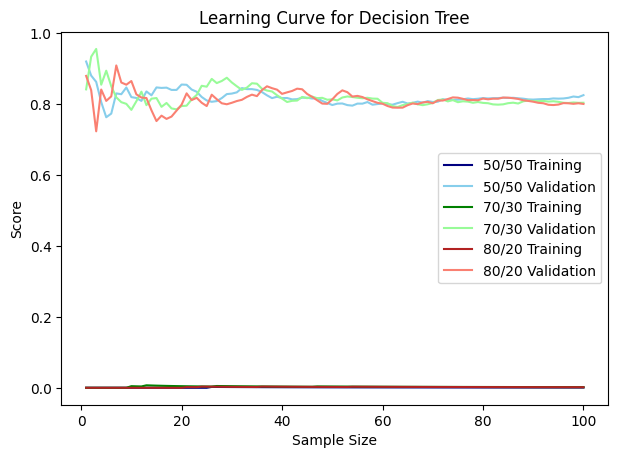

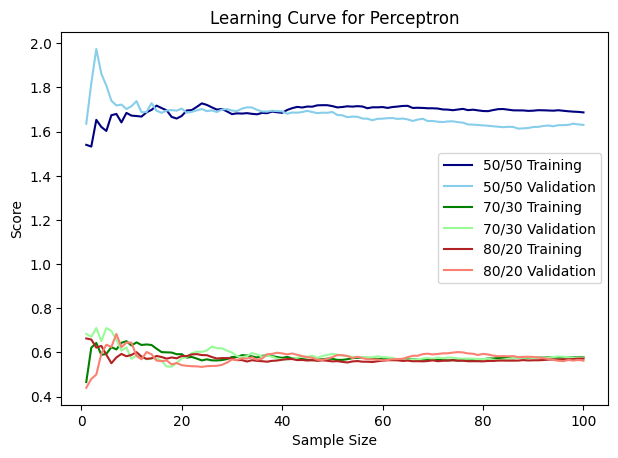

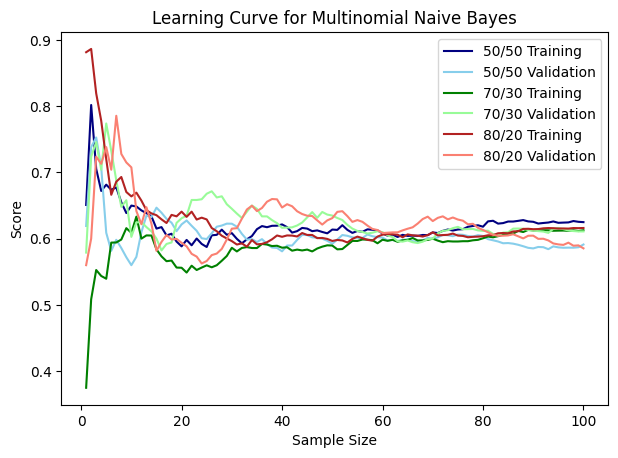

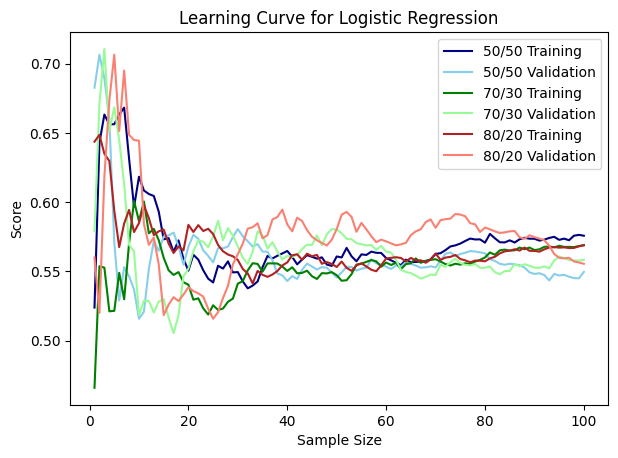

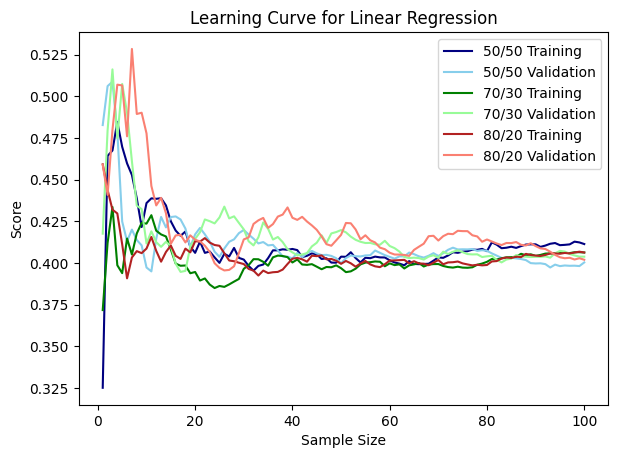

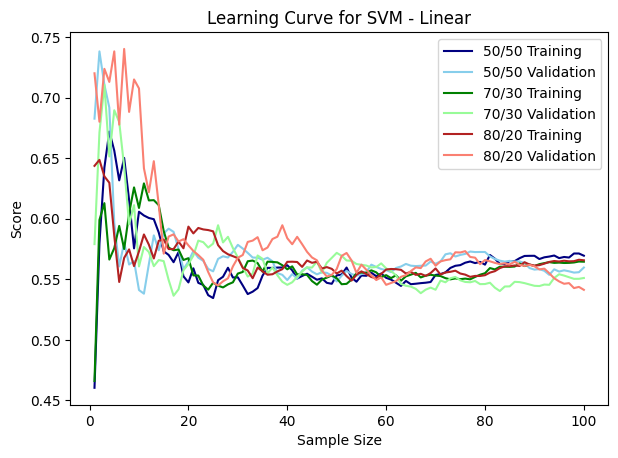

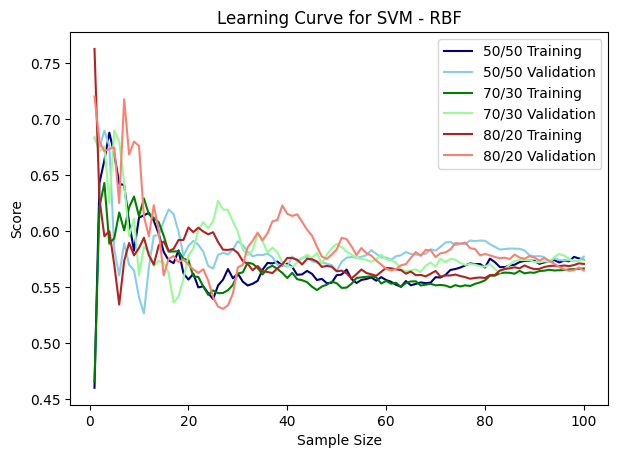

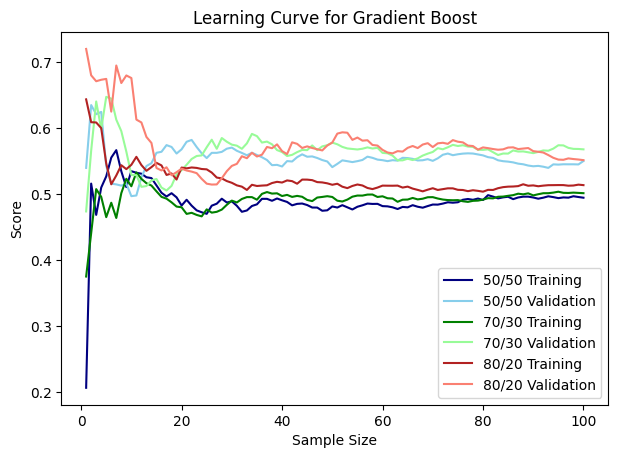

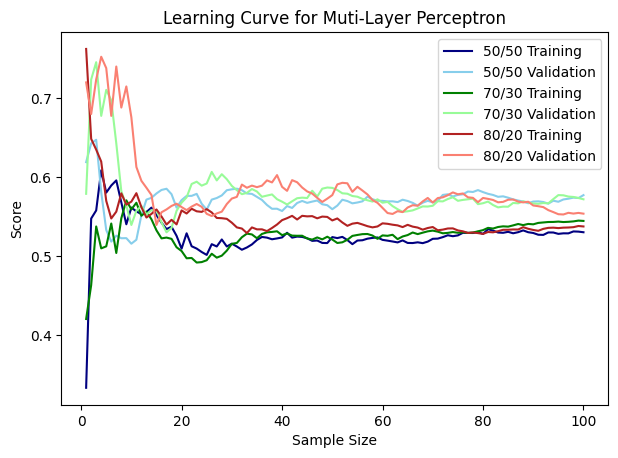

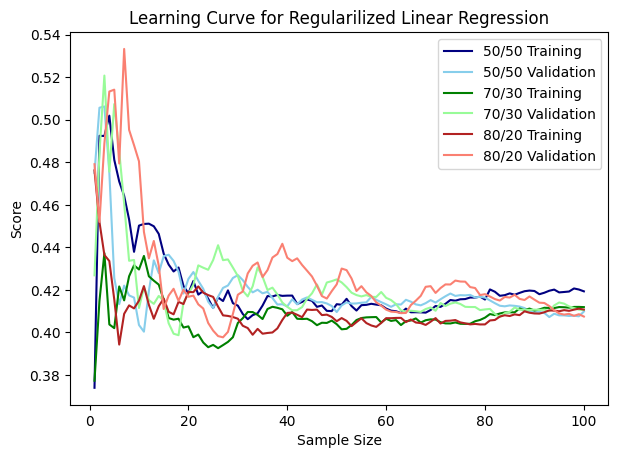

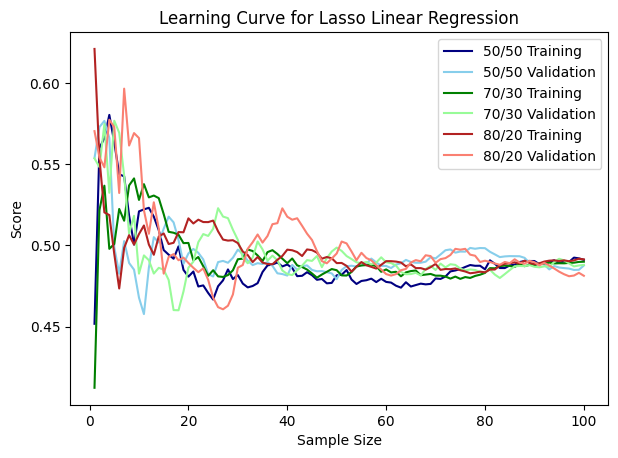

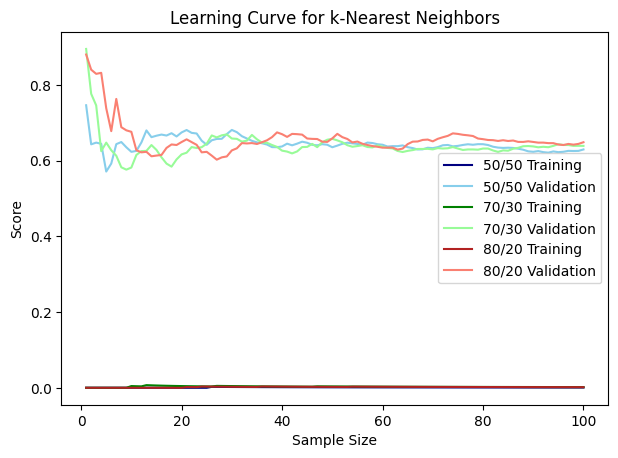

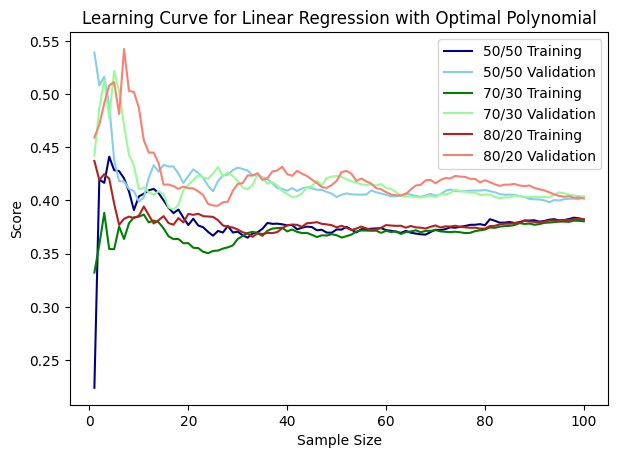

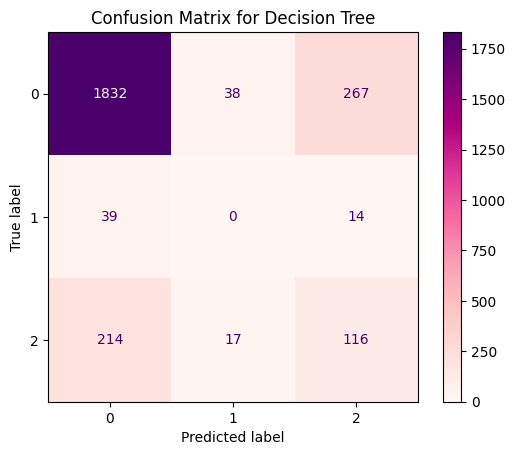

1


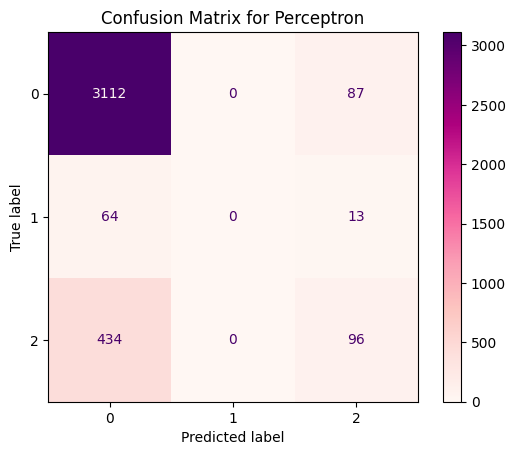

2


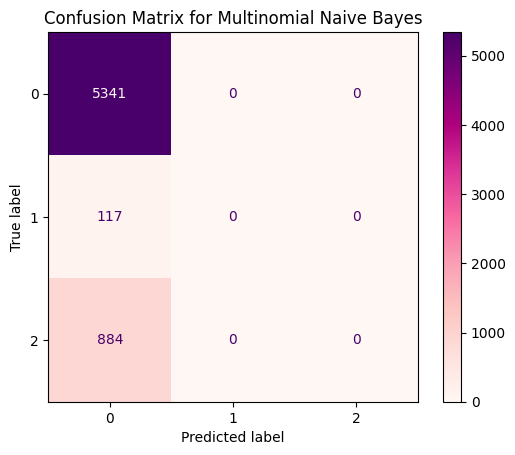

3


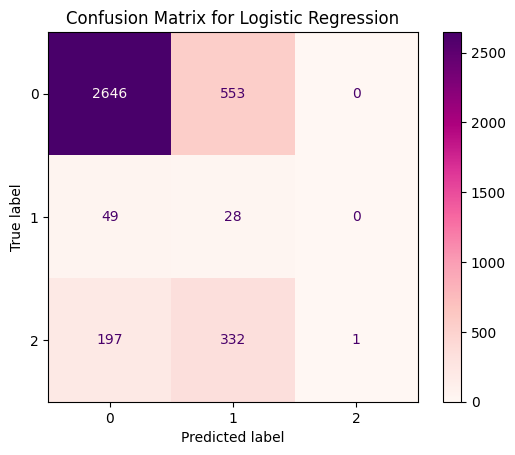

4


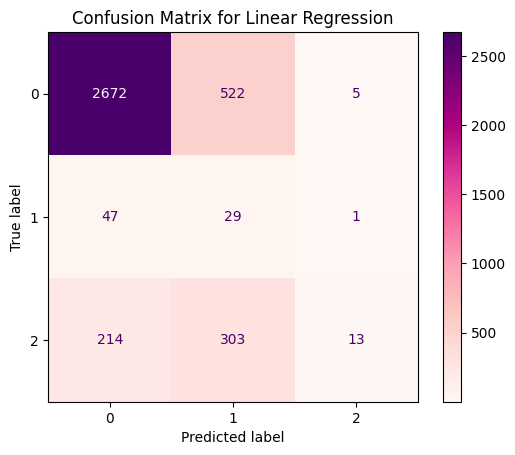

5


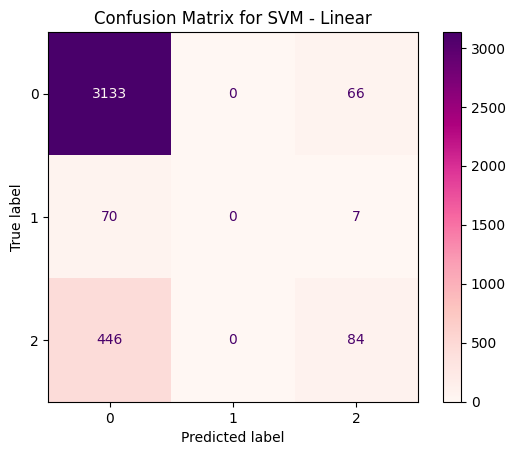

6


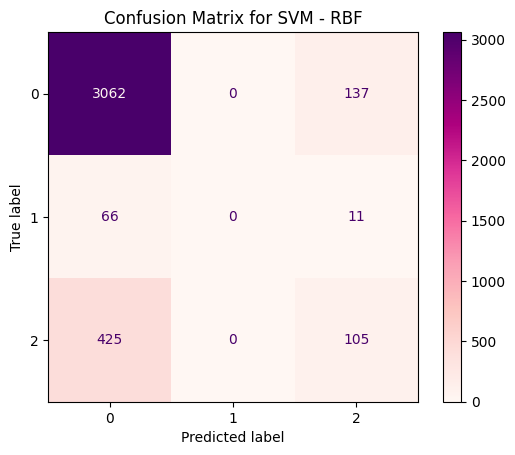

7


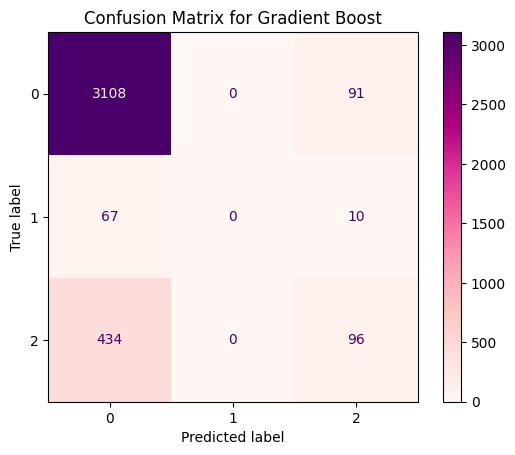

8


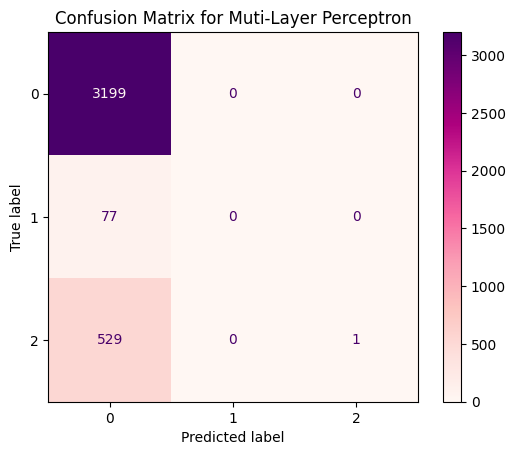

9


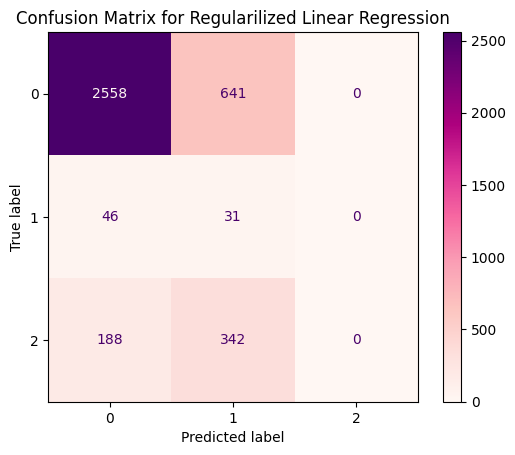

10


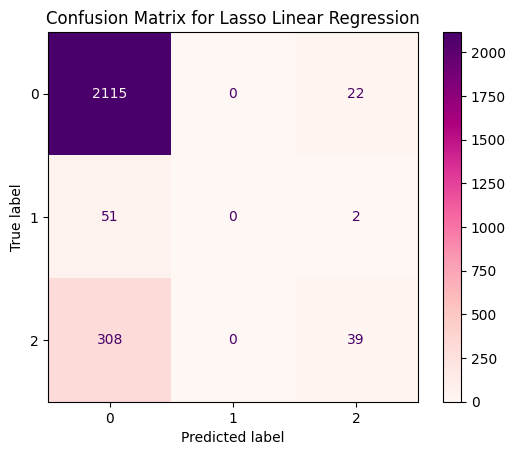

11


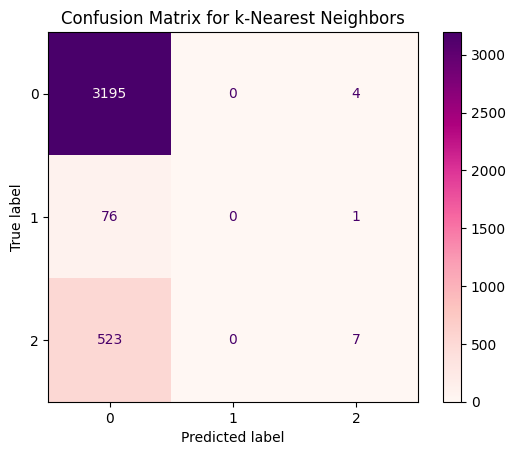

12


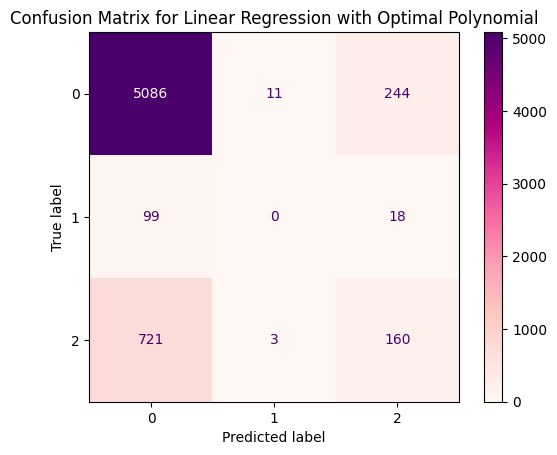

,model,split,train error,generalization
0,Decision Tree,"(0.8, 0.2)",0.749507,0.250493
1,Gradient Boost,"(0.7, 0.3)",0.505631,0.494369
2,Lasso Linear Regression,"(0.5, 0.5)",0.444707,0.444707
3,Linear Regression,"(0.7, 0.3)",0.366641,0.366641
4,Linear Regression with Optimal Polynomial,"(0.7, 0.3)",0.359907,0.359907
5,Logistic Regression,"(0.7, 0.3)",0.532658,0.467342
6,Multinomial Naive Bayes,"(0.7, 0.3)",0.532658,0.467342
7,Muti-Layer Perceptron,"(0.7, 0.3)",0.523649,0.476351
8,Perceptron,"(0.7, 0.3)",0.548423,0.451577
9,Regularilized Linear Regression,"(0.7, 0.3)",0.380537,0.380537


In [20]:
i = 0
# best_splits = pd.DataFrame(columns=['model', 
#                                     'split', 
#                                     'error', 
#                                     'generalization',
#                                     'true', 
#                                     'pred'])


splits_df = pd.DataFrame(columns=['model', 
                                  'split', 
                                  'train error', 
                                  'generalization', 
                                  'true', 
                                  'pred'])
    
for model in models:
    print(titles[i])
    pipe = make_pipeline(MinMaxScaler(), model)
    j=0
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fold_df = pd.DataFrame(columns=['accuracy',
                                    'precision', 
                                    'recall', 
                                    'f1-score', 
                                    'error'],
                                    index=index)
    
    for j in range(3): # each sample type
      
      if 'Polynomial' in titles[i]:
        poly_df = pd.DataFrame(columns=['polynomial', 'score'])
        poly = best_poly(train[j][0], train[j][1], test[j][0], test[j][1])       
        pipe = make_pipeline(MinMaxScaler(),
                             PolynomialFeatures(degree=poly),
                             LinearRegression())
        pipe.fit(train[j][0], train[j][1])
      else:
        pipe.fit(train[j][0], train[j][1])
      
      print(splits[j])
      scoring = {'accuracy' : get_acc_score, 
                  'precision' : get_prec_score,
                  'recall' : get_recall_score,
                  'f1_score':get_f1_score,
                  'error' : get_error_score,
                  'gen':get_error_score}

      m = cross_validate(pipe, 
                        train[j][0], 
                        train[j][1],
                        scoring=scoring, 
                        cv=10) 
      
      pred = pipe.predict(test[j][0])
      test_error = MSE(test[j][1], pred)

        
      fold_df = pd.concat({'accuracy':pd.Series(m['test_accuracy']), 
                            'precision':pd.Series(m['test_precision']),
                            'recall':pd.Series(m['test_recall']),
                            'f1_score':pd.Series(m['test_f1_score']),
                            'error':pd.Series(m['test_error'])},
                            axis=1)
      
      # print(sample_df['error'].min())
      splits_df.loc[len(splits_df)] = [titles[i], 
                                      splits[j], 
                                      fold_df['error'].min(),
                                      abs(fold_df['error'].min() - round(test_error)),
                                      test[j][1],
                                      pred]
      fold_df = fold_df.style.set_caption(f'Fold Metrics for {titles[i]} with {int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Split')
      fold_df.index = index
      print('\n')
      display(fold_df)
      
      # LEARNING CURVES
      train_scores = get_learning_curve(pipe, train[j][0], train[j][1], titles[i])
      test_scores = get_learning_curve(pipe, test[j][0], test[j][1], titles[i])
      ax.plot(train_scores['percent'], 
              train_scores['scores'], 
              color=train_colors[j],
              label=f'{int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Training')
      ax.plot(test_scores['percent'], 
              test_scores['scores'], 
              color=test_colors[j],
              label=f'{int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Validation')
      ax.set_xlabel('Sample Size')
      ax.set_ylabel('Score')
      ax.set_title(f'Learning Curve for {titles[i]}')
      ax.legend(loc='best')

      fig.tight_layout(pad=1.5)
      fig.show()

      j += 1

    # min = splits_df[splits_df['train error'] == splits_df['train error'].min()]
    # best_splits = pd.concat([best_splits,min], ignore_index=True)
    i+=1  

best = (splits_df.loc[splits_df.groupby('model')['train error'].idxmin()])

for b in range(len(best)):
  print(b)
  try:
    ConfusionMatrixDisplay.from_predictions(y_true=best.iloc[b]['true'], 
                                            y_pred=best.iloc[b]['pred'],
                                            cmap='RdPu')

   
  except:
    # None
    ConfusionMatrixDisplay.from_predictions(y_true=best.iloc[b]['true'], 
                                            y_pred=np.round(best.iloc[b]['pred']),
                                            cmap='RdPu')
  
  plt.title(f'Confusion Matrix for {titles[b]}')
  plt.show()
best = best.drop(['true', 'pred'], axis=1)
best.reset_index(inplace=True, drop=True)

disp_best = best.style.set_caption(f'Best Split for Each Model')
display(disp_best)

In [21]:
#
#
#
#
#
#
#
#
#

In [22]:
# # column names for dataframe with details for each split
# best_splits = pd.DataFrame(columns=['model', 
#                                     'split', 
#                                     'error', 
#                                     'generalization',
#                                     'true', 
#                                     'pred'])
# print(best_splits.columns)
# # loop through each model
# i = 0
# for model in models:
#     print(titles[i]) ###############################
#     pipe = make_pipeline(StandardScaler(), model) # create pipeline to scale data and execute model
#     j=0
#     fig = plt.figure() #initialize figures
#     ax = fig.add_subplot(1, 1, 1)
#     # dataframe to store samples
#     fold_df = pd.DataFrame(columns=['fold',
#                                     'accuracy',
#                                     'precision', 
#                                     'recall', 
#                                     'f1-score', 
#                                     'error'],
#                                     index=index)
#     # dataframe of best model
#     best_df = pd.DataFrame(columns=['model', 
#                                     'split', 
#                                     'train error', 
#                                     'generalization', 
#                                     'true', 
#                                     'pred'])
#     for j in range(3): # each sample type
      
#       if 'Polynomial' in titles[i]:
#         poly_df = pd.DataFrame(columns=['polynomial', 'score'])
#         poly = best_poly(train[j][0], train[j][1], test[j][0], test[j][1])       
#         pipe = make_pipeline(StandardScaler(),
#                              PolynomialFeatures(degree=poly),
#                              LinearRegression())
#         pipe.fit(train[j][0], train[j][1])
#       else:
#         pipe.fit(train[j][0], train[j][1])
#       print(splits[j])
#       scoring = {'accuracy' : get_acc_score, 
#                   'precision' : get_prec_score,
#                   'recall' : get_recall_score,
#                   'f1_score':get_f1_score,
#                   'error' : get_error_score,
#                   'gen':get_error_score}
#       m = cross_validate(pipe, 
#                         train[j][0], 
#                         train[j][1],
#                         scoring=scoring, 
#                         cv=10) 
#       pred = pipe.predict(test[j][0])
#       test_error = MSE(test[j][1], pred)
     
#       fold_df = pd.concat({'fold':pd.Series(index),
#                            'accuracy':pd.Series(m['test_accuracy']), 
#                            'precision':pd.Series(m['test_precision']),
#                            'recall':pd.Series(m['test_recall']),
#                            'f1_score':pd.Series(m['test_f1_score']),
#                            'error':pd.Series(m['test_error'])},
#                             axis=1)
# # ['model', 
# # 'split', 
# # 'error', 
# # 'generalization',
# # 'true', 
# # 'pred']# - test_error),
#       best_splits.loc[len(best_splits)] = [titles[i], 
#                                             splits[j], 
#                                             fold_df['error'].min(),
#                                             abs(fold_df['error'].min()),
#                                             test[j][1],
#                                             pred]
#       disp_folds = fold_df.style.set_caption(f'Fold Metrics for {titles[i]} with {int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Split')
#       # fold_df.index = index
#       print('\n')
#       display(disp_folds)
      
#       # LEARNING CURVES
#       train_scores = get_learning_curve(pipe, train[j][0], train[j][1], titles[i])
#       test_scores = get_learning_curve(pipe, test[j][0], test[j][1], titles[i])
#       ax.plot(train_scores['percent'], 
#               train_scores['scores'], 
#               color=train_colors[j],
#               label=f'{int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Training')
#       ax.plot(test_scores['percent'], 
#               test_scores['scores'], 
#               color=test_colors[j],
#               label=f'{int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Validation')
#       ax.set_xlabel('Sample Size')
#       ax.set_ylabel('Score')
#       ax.set_title(f'Learning Curve for {titles[i]}')
#       ax.legend(loc='best')
#       fig.tight_layout(pad=1.5)
#       fig.show()

#       j += 1

#     min = best_df[best_df['train error'] == best_df['train error'].min()]
#     best_splits = pd.concat([best_df,min], ignore_index=True)
#     display(best_splits)
#     print(best_df)
#     # print([fold_df[fold_df.error == fold_df.error.min()]])
#     # best = pd.concat([best_splits, fold_df[fold_df.error == fold_df.error.min()]])
#     # print(best)
#     # generalization error = diff between error on test and train set
#     i+=1  
# # best_print = best_splits['model']
# # best_print = best_print.rename(columns={'train error':'error'})
# # best_print.style.set_caption(f'Best Split for Each Model')
# # display(best_print)
# # # plt.close()
# # for b in range(len(best_splits)):
# #   try:
# #     ConfusionMatrixDisplay.from_predictions(y_true=best_splits['true'][b], 
# #                                             y_pred=best_splits['pred'][b],
# #                                             cmap='RdPu')
# #     plt.title(f'Confusion Matrix for {titles[b]}')
# #     plt.show()
# #   except:
# #     ConfusionMatrixDisplay.from_predictions(y_true=best_splits['true'][b], 
# #                                             y_pred=np.round(best_splits['pred'][b]),
# #                                             cmap='RdPu')
# #     # plt.title(f'Confusion Matrix for {titles[b]}')
# #     plt.show()